In [ ]:
# import pandas as pd

# # df_ = pd.read_excel("Total.xlsx", index_col=None)

# df = pd.ExcelFile("Total.xlsx")
# print(df.sheet_names)
# df1 = pd.read_excel(df, '1st')
# df2 = pd.read_excel(df, '2nd')
# df3 = pd.read_excel(df, '3rd')
# df_ = pd.concat([df1,df2,df3],axis=0)

# cluster = df_['Cluster'].str.split(' ', n=1, expand=True)
# cluster = cluster.rename(columns={0:'cluster', 1:'kPa'})
# features = df_.drop('Cluster', axis=1)

# df_ = pd.concat([features, cluster], axis=1)
# df_.reset_index(drop=True, inplace=True)
# df_.to_csv('Total.csv', index=False)
# print(df_)

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df = pd.read_csv('Total.csv', index_col = None)


df_ = df[df['kPa']=='22kPa']
X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
y = df_.cluster # Dependent variable
y.loc[y=='CAF'] = 0
y.loc[y=='TIF'] = 1
y = y.astype(float)

features = X.columns

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


/tmp/ipykernel_17323/1923562334.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y=='CAF'] = 0
/tmp/ipykernel_17323/1923562334.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y=='TIF'] = 1


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

X_train.shape


import shap
from sklearn.metrics import classification_report

# Random Forest

Score of RF model on test split
 0.8461538461538461
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86        66
         1.0       0.81      0.84      0.83        51

    accuracy                           0.85       117
   macro avg       0.84      0.85      0.84       117
weighted avg       0.85      0.85      0.85       117



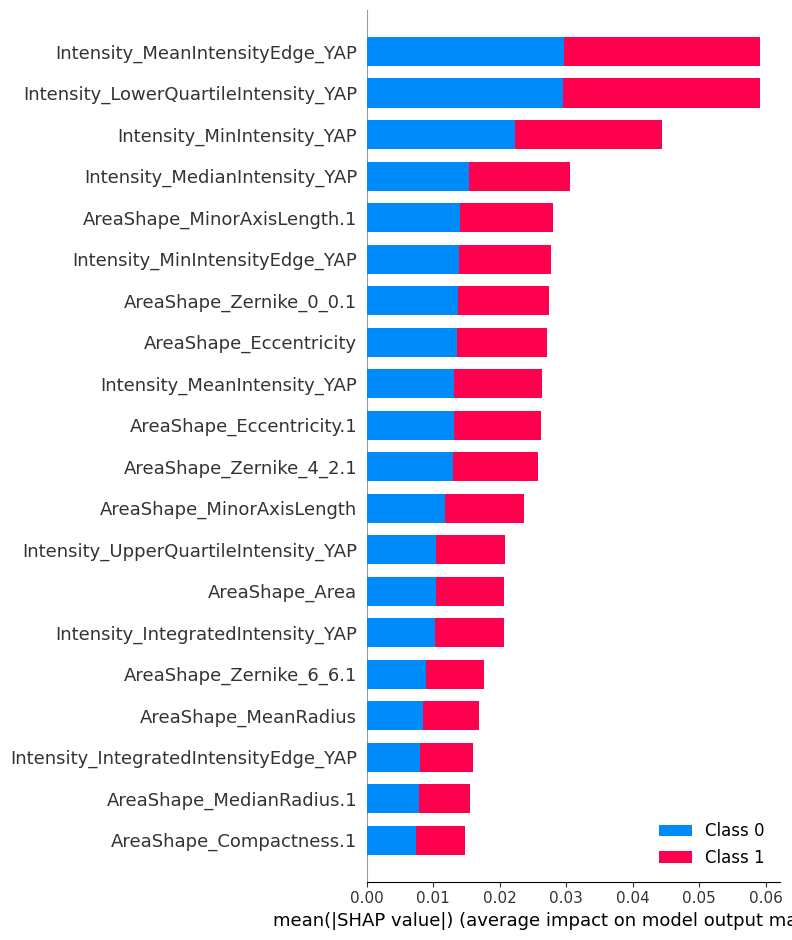

In [3]:

from sklearn.ensemble import RandomForestClassifier
shap.initjs()

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)


print('Score of RF model on test split\n',clf.score(X_test,y_test))
# Classification Report
print(classification_report(y_pred, y_test))

explainer = shap.Explainer(clf, X_train)
shap_values = explainer.shap_values(X_test)
# shap_values = shap_values.transpose(2,0,1)

# https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
shap.summary_plot(shap_values, X_test, plot_type='bar')

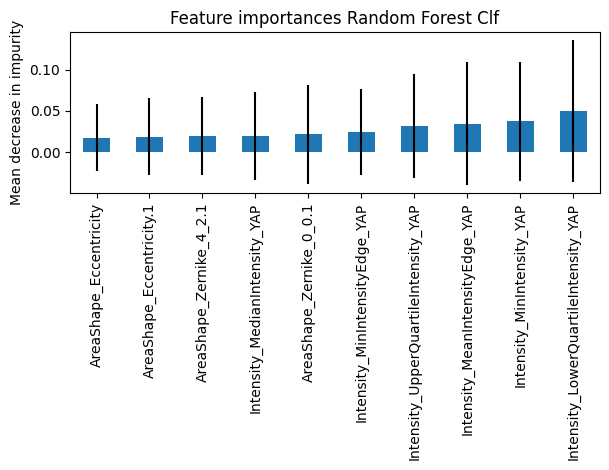

In [15]:

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

ind = np.argsort(clf.feature_importances_)[-10:]


fig, ax = plt.subplots()
feature_importances[ind].plot.bar(yerr=std[ind], ax=ax)
ax.set_title("Feature importances Random Forest Clf")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()



Score of Gradient Boosting model on test split
 0.8290598290598291


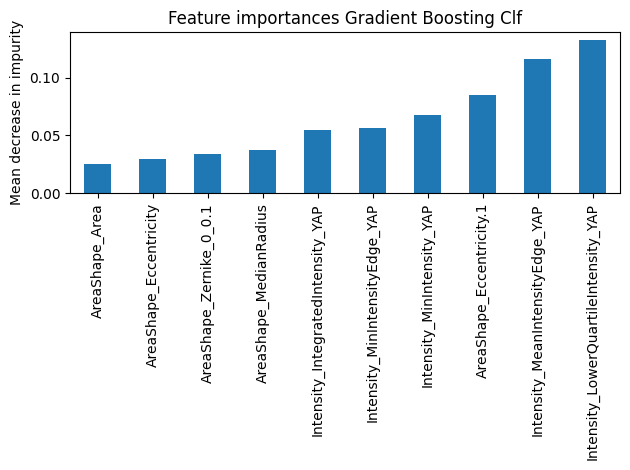

In [17]:

from sklearn.ensemble import GradientBoostingClassifier

cgf= GradientBoostingClassifier(n_estimators=100,random_state=1200)
cgf.fit(X_train,y_train)

feature_importances = pd.Series(cgf.feature_importances_, index=X_train.columns)

print('Score of Gradient Boosting model on test split\n',cgf.score(X_test,y_test))


ind = np.argsort(cgf.feature_importances_)[-10:]

fig, ax = plt.subplots()
feature_importances[ind].plot.bar(ax=ax)
ax.set_title("Feature importances Gradient Boosting Clf")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# XGBOOST

              precision    recall  f1-score   support

       False       0.83      0.85      0.84        62
        True       0.83      0.80      0.81        55

    accuracy                           0.83       117
   macro avg       0.83      0.83      0.83       117
weighted avg       0.83      0.83      0.83       117



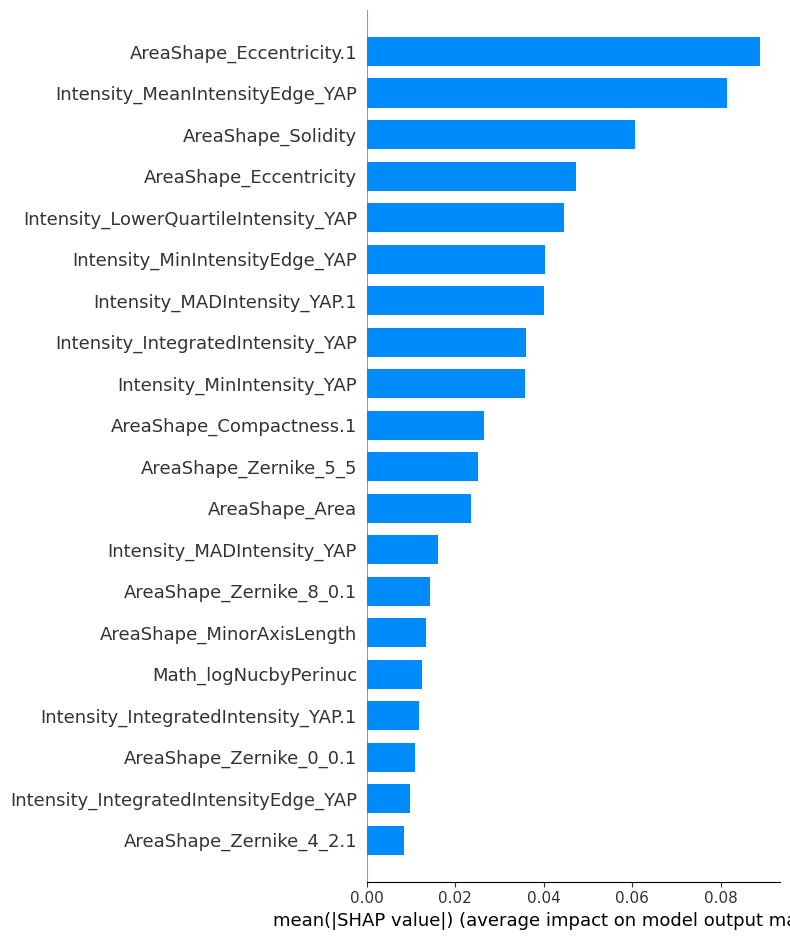

In [18]:
import xgboost

import shap

# train an XGBoost model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)


# Classification Report
y_pred = model.predict(X_test)
print(classification_report(y_pred>.5, y_test))

explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X_test, plot_type='bar')


In [19]:
import xgboost
import shap

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)



In [20]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)




[0]	test-logloss:0.68730
[100]	test-logloss:0.46355
[200]	test-logloss:0.37179
[300]	test-logloss:0.32832
[400]	test-logloss:0.30458
[500]	test-logloss:0.29133
[600]	test-logloss:0.28332
[700]	test-logloss:0.27668
[800]	test-logloss:0.27239
[840]	test-logloss:0.27092


In [21]:
y_pred = model.predict(d_test)
print(classification_report(y_pred>.5, y_test))
# xgboost.plot_importance(model)

              precision    recall  f1-score   support

       False       0.88      0.90      0.89        62
        True       0.89      0.85      0.87        55

    accuracy                           0.88       117
   macro avg       0.88      0.88      0.88       117
weighted avg       0.88      0.88      0.88       117



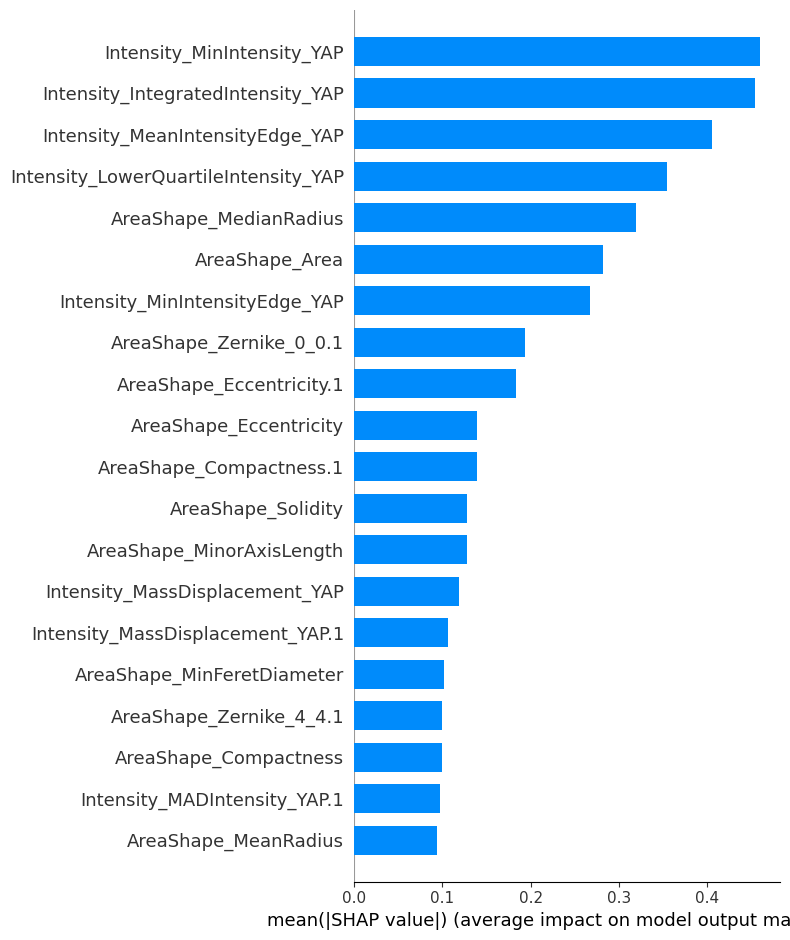

In [22]:

# Classification Report
# print(classification_report(y_pred, y_test))

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [12]:
# ## Adaptive Boost
# from sklearn import datasets
# from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
# import shap

# model = AdaBoostClassifier(random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print(classification_report(y_pred>.5, y_test))


# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# # visualize the first prediction's explanation
# # shap.plots.waterfall(shap_values[0])
# # shap.summary_plot(shap_values, X_test, plot_type='bar')

              precision    recall  f1-score   support

       False       0.92      0.88      0.90        67
        True       0.85      0.90      0.87        50

    accuracy                           0.89       117
   macro avg       0.89      0.89      0.89       117
weighted avg       0.89      0.89      0.89       117



InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

# Logistic regression

In [15]:


import seaborn as sns
sns.pairplot(X_train, hue="price_range", height=2.5)

In [9]:
import sklearn

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79        64
         1.0       0.77      0.64      0.70        53

    accuracy                           0.75       117
   macro avg       0.76      0.74      0.74       117
weighted avg       0.75      0.75      0.75       117



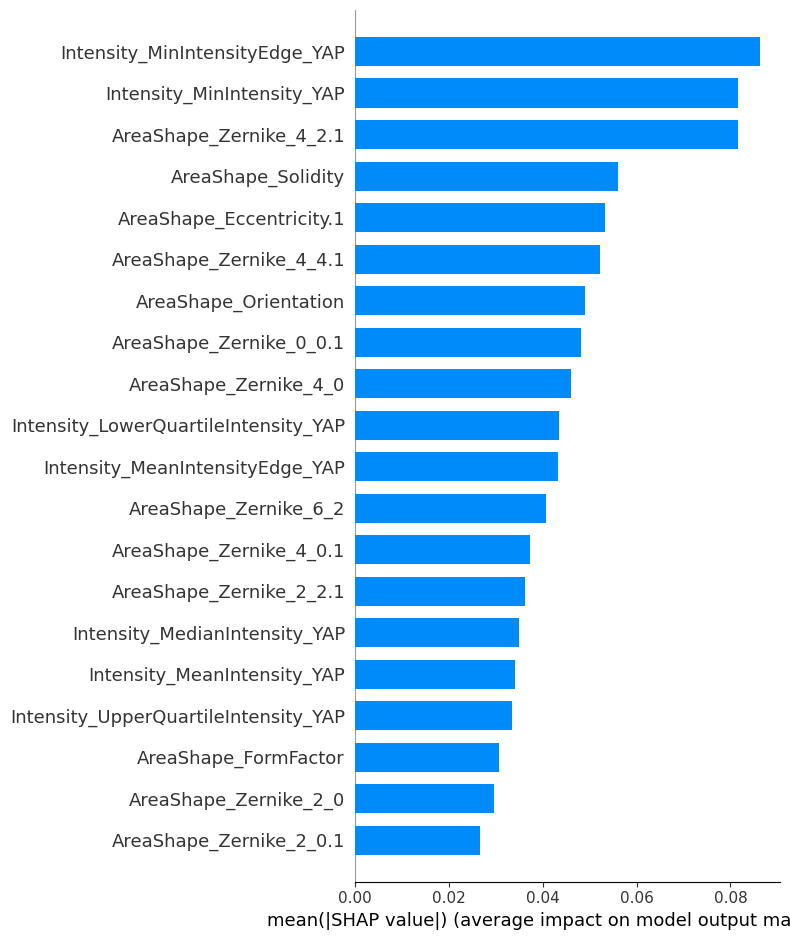

In [12]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [9]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

testShap = 1000
explainers = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, testShap))

Using 272 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/117 [00:00<?, ?it/s]

[array([[-0.01411941,  0.0021381 ,  0.03852952, ...,  0.        ,
         -0.01889811,  0.00323008],
        [ 0.00763076,  0.00281545,  0.01426954, ...,  0.        ,
          0.00504389,  0.00223396],
        [-0.00716414,  0.00203528, -0.02733065, ...,  0.00099556,
         -0.01255574, -0.00045398],
        ...,
        [ 0.        ,  0.00511625, -0.03846368, ..., -0.00486191,
         -0.01089117,  0.        ],
        [ 0.00115133,  0.00469336,  0.00815497, ...,  0.        ,
          0.0101513 , -0.00209755],
        [-0.01063101,  0.00222474,  0.01714629, ...,  0.00808822,
         -0.02186379, -0.00279563]]),
 array([[ 0.01411941, -0.0021381 , -0.03852952, ...,  0.        ,
          0.01889811, -0.00323008],
        [-0.00763076, -0.00281545, -0.01426954, ...,  0.        ,
         -0.00504389, -0.00223396],
        [ 0.00716414, -0.00203528,  0.02733065, ..., -0.00099556,
          0.01255574,  0.00045398],
        ...,
        [ 0.        , -0.00511625,  0.03846368, ...,  

  0%|          | 0/117 [00:00<?, ?it/s]

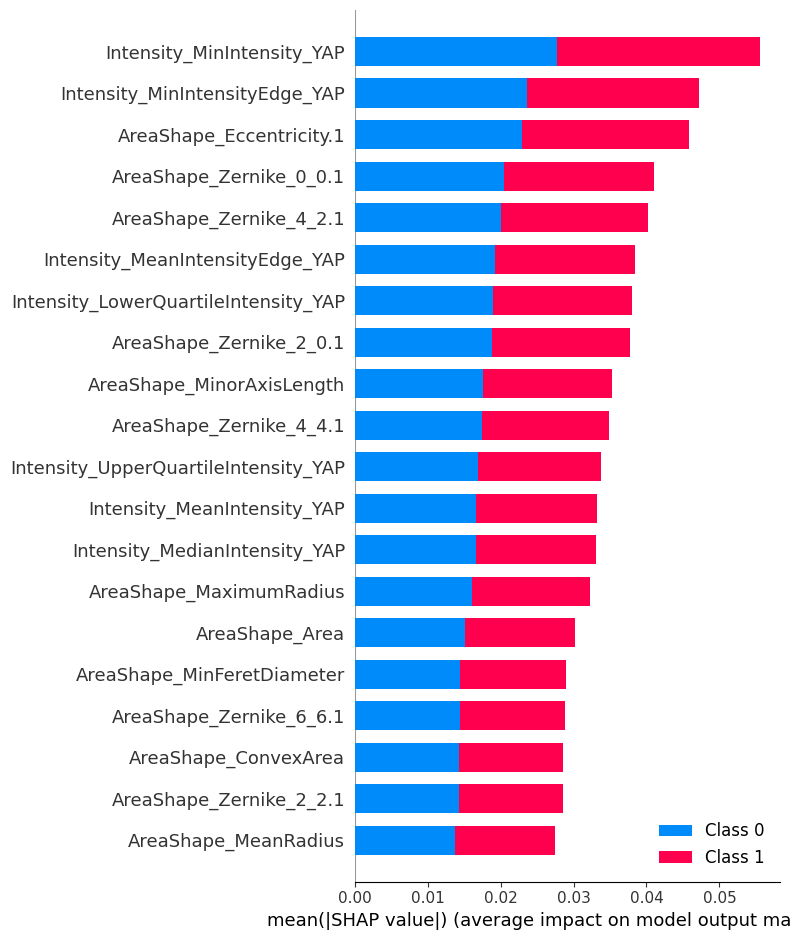

In [11]:

shap_values = explainers.shap_values(X_test)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='bar')